In [267]:
# standard libs
import os
import sys
import logging

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
from prediction_age import AgePredictor
from preprocessing import *

# external libs
import pandas as pd
import geopandas as gpd
from shapely import wkt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier

In [3]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

In [164]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [86]:
path_data_france = os.path.join('..', 'data', 'france-cities-200.csv')
data_france = pd.read_csv(path_data_france)

In [253]:
len(data_france.dropna(subset=[dataset.AGE_ATTRIBUTE])) / len(data_france)

0.4109978305234059

In [62]:
import glob

geom_files = glob.glob('../data_france/geographics/*/*_geom.csv') + glob.glob('../data_france/geographics/*_geom.csv')
data_geom = pd.concat((pd.read_csv(f) for f in geom_files), ignore_index=True)


## Data Preparation

In [249]:
data_geom_w_age = pd.concat([data_geom.set_index('id'), data_france[['id', dataset.AGE_ATTRIBUTE]].set_index('id')], axis=1, join="inner").reset_index()
data_geom_w_age = data_geom_w_age.dropna(subset=[dataset.AGE_ATTRIBUTE])

data_france_w_geo = data_france[data_france['id'].isin(data_geom['id'])]

In [263]:
%matplotlib inline

predictor_80_20 = AgePredictor(
    model=XGBRegressor(),
    df=data_france_w_geo,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_outliers, remove_other_attributes]
)
predictor_80_20.evaluate_regression()

2022-01-17 10:53:28,411 | INFO : Dataset length: 180913
2022-01-17 10:53:28,665 | INFO : Test dataset length: 36183
2022-01-17 10:53:28,666 | INFO : Training dataset length: 144730
2022-01-17 10:53:28,668 | INFO : Standard deviation of test set: 60.834110331421776
2022-01-17 10:53:28,947 | INFO : Test dataset length after preprocessing: 14450
2022-01-17 10:53:28,948 | INFO : Training dataset length after preprocessing: 58115


MAE: 14.512991981374352 y
RMSE: 20.01273881521049 y
R2: 0.5072442909360135


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


2022-01-17 10:57:41,780 | INFO : Dataset length: 180913
2022-01-17 10:57:41,897 | INFO : Test dataset length: 12199
2022-01-17 10:57:41,897 | INFO : Training dataset length: 168714
2022-01-17 10:57:41,898 | INFO : Standard deviation of test set: 59.61299007131891
2022-01-17 10:57:42,056 | INFO : Test dataset length after preprocessing: 5899
2022-01-17 10:57:42,057 | INFO : Training dataset length after preprocessing: 66666


MAE: 19.092401370332894 y
RMSE: 24.02816430436355 y
R2: -0.07114111356902209


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


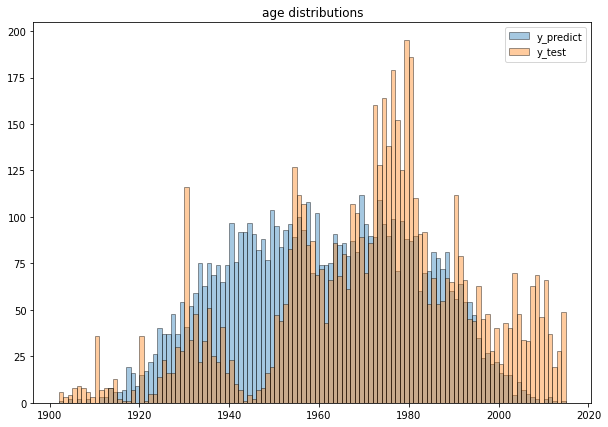

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

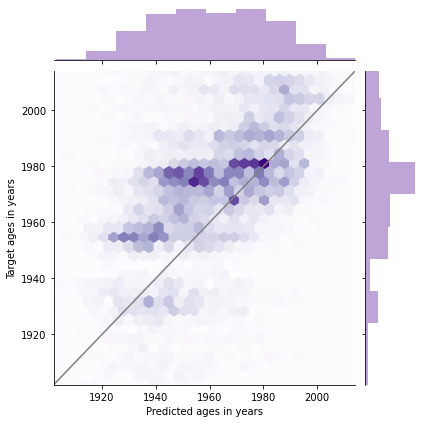

In [264]:
%matplotlib inline

predictor_city_split = AgePredictor(
    model=XGBRegressor(),
    df=data_france_w_geo,
    test_training_split=split_by_city,
    preprocessing_stages=[remove_outliers, remove_other_attributes]
)
predictor_city_split.evaluate_regression()

## Visualizations

In [265]:
%matplotlib qt

### Age

In [258]:
visualizations.plot_age_on_map(data_geom_w_age)

### Prediction error

In [262]:
# only 20% of all city buildings are plotted (makes it hard to understand impact of neighborhood structure on prediction error)
data_france_bourgenbresse = data_france_w_geo[data_france_w_geo['city'] == 'Bourg-en-Bresse']
data_geo_bourgenbresse = data_geom[data_geom['id'].isin(data_france_bourgenbresse['id'])]

prediction_error = predictor_80_20.individual_prediction_error()
visualizations.plot_prediction_error_on_map(prediction_error, data_geo_bourgenbresse)

In [266]:
# all buildings for a single city are plotted (higher prediction error though compared to 80/20 split)
prediction_error = predictor_city_split.individual_prediction_error()
visualizations.plot_prediction_error_on_map(prediction_error, data_geom)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Impact of geographical heterogenity on prediction error

In [283]:
data_france_w_geo_column = pd.concat([data_france.set_index('id'), data_geom.set_index('id')], axis=1, join="inner").reset_index()

gdf = gpd.GeoDataFrame(data_france_w_geo_column,
                    geometry=data_france_w_geo_column['geometry'].apply(wkt.loads),
                    crs=7794)

In [294]:
# utils.get_indexes_right_round_buffer(gdf.copy(), gdf.copy(), 100)
building_gdf_for_join = gpd.GeoDataFrame(geometry=gdf.geometry)

# # Create a gdf with a buffer per object of interest as a single geometry column
buffer = gdf.geometry.centroid.buffer(100).values
gpd.GeoDataFrame(geometry=buffer).info()
# joined_gdf = gpd.sjoin(buffer_gdf, building_gdf_for_join, how="left", op="intersects")


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 180913 entries, 0 to 180912
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   geometry  180913 non-null  geometry
dtypes: geometry(1)
memory usage: 1.4 MB


In [295]:
gpd.GeoDataFrame(geometry=gdf.geometry).info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 180913 entries, 0 to 180912
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   geometry  180913 non-null  geometry
dtypes: geometry(1)
memory usage: 1.4 MB
